In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from PIL import Image
plt.rcParams['figure.figsize'] = 15, 10

# 生成测试数据

In [2]:
DEBUG = False
# 取出文本框
def get_text_rect(image):
    img = image.copy()

    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(21,7),0)


    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
    # plt.imshow(img,'gray')
    # plt.show()

    element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    img = cv2.erode(img, element)
    # plt.imshow(img,'gray')
    # plt.show()

    img = cv2.dilate(img, element)
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()

    img = cv2.blur(img, tuple((5, 5)))
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()
    
    # 去黑边
    vertical = np.copy(img)
    cols = vertical.shape[1]
    vertical_size = int(cols / 40)
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)

    vertical = cv2.blur(vertical, tuple((3, 3)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((17, 17)), (-1, -1))
    vertical = cv2.dilate(vertical, element, iterations=1)
    vertical = cv2.bitwise_not(vertical)
    img = cv2.bitwise_and(img,vertical)    
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()    

    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((13, 5)), (-1, -1))
    img = cv2.dilate(img, element, iterations=2)
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()
    
    nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    # print(contours)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w > 150 and w < 400:
            cnts.append([y,x,h,w])
    return cnts

def check_in_areas(rect_lists):
    in_area = []
    for idx, rect in enumerate(rect_lists):
        y, x, h, w = rect
        for step,item in enumerate(rect_lists):
            if idx != step:
                iy, ix, ih, iw = item
                if y > iy and x > ix and (y + h) < (iy + ih) and (x + w) < (ix + iw):
                    in_area.append(idx)
    return rect_lists


# 取出字符文档框
def get_char_rect(image):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # plt.imshow(img,'gray')
    # plt.show()
    img = cv2.GaussianBlur(img,(3,3),0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
    # plt.imshow(img,'gray')
    # plt.show()

    start_time = time.time()

    # 去燥点
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    img = cv2.erode(img, element)
    img = cv2.dilate(img, element,iterations=4)
    plt.imshow(img,'gray')
    plt.show()

    nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:    
            rect = cv2.boundingRect(cnt)
#             if rect[2] >= 15:
            x,y,w,h = rect
            if w/h > 0.35:
                cnts.append([y,x,h,w])
    y_median = np.median(np.array(cnts)[:,0])
    cnts = [x for x in cnts if abs(x[0]-y_median) < 10]
    in_area_idxs = check_in_areas(cnts)
    cnts = [x for ix,x in enumerate(cnts) if ix not in in_area_idxs]    
    del img
    return cnts

# 对文本框位置列表信息按Y、X坐标点进行排序
# rect_list: 边框（y,x,h,w)位置列表， 类型 list
# 返回排序号的rect_list, 类型list
def text_rect_sort(rect_list):
    rects = np.array(rect_list)
    print('y mean --> {}'.format(np.mean(rects[:,0])))
    print('y std --> {}'.format(np.std(rects[:,0])))
    
    if np.std(rects[:,0]) < 10:
        # std 小于10 表明数据在一行，不需再作特殊处理
        ridx = np.lexsort([rects[:,1]])
        rects = rects[ridx]    
    else:
        ridx = np.lexsort([rects[:,1],rects[:,0]])
        rects = rects[ridx]
        # 对边框按坐标点Y进行区间划分
        rect_area = (rects[:, 0] - rects[0][0])/ np.std(rects[:, 0],ddof=1)
        rect_area = np.around(rect_area,1) 

        rect_current_class = 0
        rect_class = [rect_current_class]
        for inx in range(1, len(rect_area)):
            if abs(rect_area[inx] - rect_area[inx-1]) > 0.5:
                rect_current_class = rect_current_class + 1
            rect_class.append(rect_current_class)        

        rects = np.insert(rects,4,values=np.array(rect_class),axis=1)
        ridx = np.lexsort([rects[:,1],rects[:,4]])
        rects = rects[ridx]
    return rects[:,0:4].tolist()

def answer_bind_rect(rect_list, answer_list):
    rect_len = len(rect_list)
    answer_len = len(answer_list)
    answers = {answer_list[answer_len-idx-1]:rect_list[rect_len-idx -1] for idx in range(answer_len)}
    return answers
    

In [11]:
# 读取数据
from common.examdetect import EXDetect
clip_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\'

# moible define
# qlists = [0,1,2,4]
# qdefines = {0:[1, 2, 3, 4, 5, 6],1:[7,8,9,10,11,12,13,14],2:[15, 16, 17, 18, 19, 20],
#             4:[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]}
# answerdefines = { 
#     1:'A-CDEF',2:'ABC-EF',3:'ABC-EF',4:'AB-DEF',5:'ABCDE-',6:'-BCDEF',7:'-BCD',8:'ABC-',
#     9:'AB-D',10:'AB-D',11:'-BCD',12:'AB-D',13:'AB-D',14:'-BCD',15:'T-',16:'-F',17:'T-',
#     18:'-F',19:'T-',20:'T-',26:'-BCD',27:'A-CD',28:'AB-D',29:'-BCD',30:'ABC-',31:'AB-D',
#     32:'-BCD',33:'AB-D',34:'A-CD',35:'A-CD',36:'ABC-',37:'A-CD',38:'-BCD',39:'-BCD',40:'A-CD',
#     41:'-BCD',42:'AB-D',43:'A-CD',44:'A-CD',45:'AB-D'
# }


# mobile3 define
# qlists = [0,1]
# qdefines = {0:[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93],1:[94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105]}
# answerdefines = {82:'-BCDE',83:'-BCDE',84:'ABCD-',85:'-BCDE',86:'A-CDE',87:'ABC-E',
#                  88:'A-CDE',89:'A-CDE',90:'-BCDE',91:'ABCD-',92:'ABC-E',93:'ABCD-',
#                  94:'--CDE',95:'-BCD-',96:'AB-D-',97:'A-CDE',98:'AB-DE',99:'A--D-',
#                  100:'-BCDE',101:'A-CD-',102:'AB-DE',103:'ABC-E',104:'A--DE',105:'-BCDE'
#                 }

# mobile3 define
qlists = [0,]
qdefines = {0:[50, 51, 52, 53, 53, 55, 56, 57, 58, 59],2:[66,67,68,69,70,71,72]}
answerdefines = {50:'-BCD',51:'-BCD',52:'A-CD',53:'-BCD',54:'A-CD',55:'AB-D',
                 56:'AB-D',57:'ABC-',58:'ABC-',59:'A-CD',68:'-F',69:'-F',
                 70:'T-',71:'-F',72:'-F'}

# filename = '乐视2max'
path = 'D:\\PROJECT_TW\\examrc\\data\\exam\\mobile_4\\'

file_list = os.listdir(path)
# file_list = [x for x in file_list if x.endswith('jpg')]
file_list = ['小米5.jpg',]
for item in file_list:
    filename = item.split('.')[0]
    print('------------ 开始处理 {} -----------------'.format(filename))
    with  open('{}{}'.format(path,item),'rb') as f:
        imgb = f.read()
    image_bin = np.frombuffer(imgb, np.uint8)    
    exd = EXDetect(id=1, image=image_bin, mobile_type='default')
    # 分隔试卷，取出包含选择题的项
    regions = exd.clip_exam()

    for qidx in qlists:
        y,x,h,w = regions[qidx]
        rect_list = get_text_rect(exd.origin_image[y:y+h,x:x+w])
        cv2.imwrite('d:\\clip_11.jpg',exd.origin_image[y:y+h,x:x+w])
        rect_list = text_rect_sort(rect_list)
        print(rect_list)
        answers = answer_bind_rect(rect_list, qdefines[qidx])
        print(answers)
        for ans_no in answers.keys():
            ay,ax,ah,aw = answers[ans_no]
            rimg = exd.origin_image[y+ay:y+ay+ah, x+ax:x+ax+aw]
#             with open('{}{}_{}_{}.jpg'.format(clip_path,filename,ans_no,answerdefines[ans_no]),'wb') as f:
#                 imgbin = cv2.imencode('.jpg',rimg)[1]
#                 f.write(imgbin)
            
    


------------ 开始处理 小米5 -----------------
[[874, 977, 31, 511], [876, 339, 28, 513], [954, 977, 31, 511], [955, 339, 29, 513], [1034, 979, 31, 508], [1035, 340, 29, 513], [1113, 979, 31, 508], [1115, 341, 29, 513], [1569, 345, 31, 1322], [1647, 346, 31, 1320], [1725, 345, 31, 1321], [1804, 346, 31, 1321], [1882, 347, 31, 1320], [1960, 348, 32, 1319], [2038, 347, 32, 1321], [2116, 348, 33, 1322], [2195, 347, 33, 1324]]
[[354, 212, 348, 1666], [702, 212, 509, 1667], [1211, 214, 190, 1664], [1401, 216, 896, 1661]]
y mean --> 208.7
y std --> 59.9550665081776
[[148, 78, 43, 278], [146, 482, 43, 279], [143, 886, 45, 279], [142, 1290, 43, 280], [227, 77, 42, 279], [226, 481, 43, 280], [223, 886, 44, 279], [222, 1291, 42, 279], [306, 76, 42, 280], [304, 482, 44, 279]]
{59: [304, 482, 44, 279], 58: [306, 76, 42, 280], 57: [222, 1291, 42, 279], 56: [223, 886, 44, 279], 55: [226, 481, 43, 280], 53: [142, 1290, 43, 280], 52: [143, 886, 45, 279], 51: [146, 482, 43, 279], 50: [148, 78, 43, 278]}


In [19]:
# 从文本框提取字符
import time
clip_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\'
clip_save_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\'
clip_file_name = '23_A-CD'
b_number = 0
n_number = 0

files = os.listdir(clip_path)
# files = ['360n4s_17_T-.jpg',]
start_time = time.time()
for file in files:
    clip_file_name = file.split('.')[0]
    print(clip_file_name)
#     image = cv2.imread('{}{}.jpg'.format(clip_path,clip_file_name),cv2.IMREAD_COLOR)
    with open('{}{}.jpg'.format(clip_path,clip_file_name),'rb') as ff:
        imgbin = ff.read()
    
    imgbin = np.frombuffer(imgbin, np.uint8)    
    image = cv2.imdecode(imgbin,cv2.IMREAD_COLOR)
    
#     print(image.shape)
    cnts = get_char_rect(image)
    cnts_array = np.array(cnts)
    cnts_inx = np.lexsort([cnts_array[:,1]])
    cnts_array = cnts_array[cnts_inx]
    cnts = cnts_array.tolist()
    if len(cnts) < (len(clip_file_name.split('_')[-1])):
        raise Exception('{} 切割失败 切割长度 {} 最少长度 {}'.format(clip_file_name,len(cnts), 
                                                         (len(clip_file_name.split('_')[-1]) + 1)))
    
    binx = [idx for idx,x in enumerate(clip_file_name.split('_')[-1]) if x =='-']
    # 取坐标后几位
    cnts = cnts[len(cnts)-len(clip_file_name.split('_')[-1]):]
    for i, (y,x,h,w) in enumerate(cnts):
        crop_img = image[y:y+h,x:x+w]
        if i in binx:
            cv2.imwrite('{}1_{}.jpg'.format(clip_save_path,b_number),crop_img)
            b_number = b_number + 1
        else:
            cv2.imwrite('{}0_{}.jpg'.format(clip_save_path,n_number),crop_img)
            n_number = n_number + 1
        

print('total files {}  time {:.4f}'.format(len(files),(time.time() - start_time)))
    
        

360n4s_10_AB-D
360n4s_11_-BCD
360n4s_12_AB-D
360n4s_13_AB-D
360n4s_14_-BCD
360n4s_15_T-
360n4s_16_-F
360n4s_17_T-
360n4s_18_-F
360n4s_19_T-
360n4s_1_A-CDEF
360n4s_20_T-
360n4s_26_-BCD
360n4s_27_A-CD
360n4s_28_AB-D
360n4s_29_-BCD
360n4s_2_ABC-EF
360n4s_30_ABC-
360n4s_31_AB-D
360n4s_32_-BCD
360n4s_33_AB-D
360n4s_34_A-CD
360n4s_35_A-CD
360n4s_36_ABC-
360n4s_37_A-CD
360n4s_38_-BCD
360n4s_39_-BCD
360n4s_3_ABC-EF
360n4s_40_A-CD
360n4s_41_-BCD
360n4s_42_AB-D
360n4s_43_A-CD
360n4s_44_A-CD
360n4s_45_AB-D
360n4s_4_AB-DEF
360n4s_5_ABCDE-
360n4s_6_-BCDEF
360n4s_7_-BCD
360n4s_8_ABC-
360n4s_9_AB-D
iphone6p_10_AB-D
iphone6p_11_-BCD
iphone6p_12_AB-D
iphone6p_13_AB-D
iphone6p_14_-BCD
iphone6p_15_T-
iphone6p_16_-F
iphone6p_17_T-
iphone6p_18_-F
iphone6p_19_T-
iphone6p_1_A-CDEF
iphone6p_20_T-
iphone6p_26_-BCD
iphone6p_27_A-CD
iphone6p_28_AB-D
iphone6p_29_-BCD
iphone6p_2_ABC-EF
iphone6p_30_ABC-
iphone6p_31_AB-D
iphone6p_32_-BCD
iphone6p_33_AB-D
iphone6p_34_A-CD
iphone6p_35_A-CD
iphone6p_36_ABC-
iphone6p_37

华为荣耀V8_3_ABC-EF
华为荣耀V8_40_A-CD
华为荣耀V8_41_-BCD
华为荣耀V8_42_AB-D
华为荣耀V8_43_A-CD
华为荣耀V8_44_A-CD
华为荣耀V8_45_AB-D
华为荣耀V8_4_AB-DEF
华为荣耀V8_5_ABCDE-
华为荣耀V8_6_-BCDEF
华为荣耀V8_7_-BCD
华为荣耀V8_8_ABC-
华为荣耀V8_9_AB-D
小米5_100_-BCDE
小米5_101_A-CD-
小米5_102_AB-DE
小米5_103_ABC-E
小米5_104_A--DE
小米5_105_-BCDE
小米5_10_AB-D
小米5_11_-BCD
小米5_12_AB-D
小米5_13_AB-D
小米5_14_-BCD
小米5_15_T-
小米5_16_-F
小米5_17_T-
小米5_18_-F
小米5_19_T-
小米5_1_A-CDEF
小米5_20_T-
小米5_26_-BCD
小米5_27_A-CD
小米5_28_AB-D
小米5_29_-BCD
小米5_2_ABC-EF
小米5_30_ABC-
小米5_31_AB-D
小米5_32_-BCD
小米5_33_AB-D
小米5_34_A-CD
小米5_35_A-CD
小米5_36_ABC-
小米5_37_A-CD
小米5_38_-BCD
小米5_39_-BCD
小米5_3_ABC-EF
小米5_40_A-CD
小米5_41_-BCD
小米5_42_AB-D
小米5_43_A-CD
小米5_44_A-CD
小米5_45_AB-D
小米5_4_AB-DEF
小米5_5_ABCDE-
小米5_6_-BCDEF
小米5_7_-BCD
小米5_82_-BCDE
小米5_83_-BCDE
小米5_84_ABCD-
小米5_85_-BCDE
小米5_86_A-CDE
小米5_87_ABC-E
小米5_88_A-CDE
小米5_89_A-CDE
小米5_8_ABC-
小米5_90_-BCDE
小米5_91_ABCD-
小米5_92_ABC-E
小米5_93_ABCD-
小米5_94_--CDE
小米5_95_-BCD-
小米5_96_AB-D-
小米5_97_A-CDE
小米5_98_AB-DE
小米5_99_A--D-
小米5_9_AB-D
小米6_10_AB-D
小米6

# 数据准备

In [3]:
# https://github.com/pytorch/vision/issues/81

# 将图片数据写入到LMDB数据库存中

import lmdb
import glob
import random
# 创建数据库
# import lmdb  # install lmdb by "pip install lmdb"
# env = lmdb.open('./data/lmdb', map_size=511627776)
# env = lmdb.open('./data/lmdb', map_size=511627776)
# from genLineText import GenTextImage
def checkImageIsValid(imageBin):
    if imageBin is None:
        return False
    
    imageBuf = np.frombuffer(imageBin, dtype=np.uint8)
    img = cv2.imdecode(imageBuf, cv2.IMREAD_COLOR)
    if img is None:
        return False
    imgH, imgW = img.shape[0], img.shape[1]
    if imgH * imgW == 0:
        return False
    return True

def writeCache(env, cache):
    with env.begin(write=True) as txn:
        for k, v in cache.items():
            txn.put(k.encode(), v)
            
def createDataset(outputPath, imagePathList, labelList, lexiconList=None, checkValid=True):
    """
    Create LMDB dataset for CRNN training.
    ARGS:
        outputPath    : LMDB output path
        imagePathList : list of image path
        labelList     : list of corresponding groundtruth texts
        lexiconList   : (optional) list of lexicon lists
        checkValid    : if true, check the validity of every image
    """
    # print (len(imagePathList) , len(labelList))
    assert (len(imagePathList) == len(labelList))
    nSamples = len(imagePathList)
    
    env = lmdb.open(outputPath, map_size=511627776)

    cache = {}
    cnt = 1
    for i in range(nSamples):
        imagePath = imagePathList[i]
        label = labelList[i]
        if not os.path.exists(imagePath):
            print('%s does not exist' % imagePath)
            continue
        with open(imagePath, 'rb') as f:
            imageBin = f.read()
        
        if checkValid:
            if not checkImageIsValid(imageBin):
                print('%s is not a valid image' % imagePath)
                continue

        imageKey = 'image-%09d' % cnt
        labelKey = 'label-%09d' % cnt
        cache[imageKey] = imageBin
        cache[labelKey] = label.encode()
        if lexiconList:
            lexiconKey = 'lexicon-%09d' % cnt
            cache[lexiconKey] = ' '.join(lexiconList[i]).encode()
        if cnt % 1000 == 0:
            writeCache(env, cache)
            cache = {}
            print('Written %d / %d' % (cnt, nSamples))
        cnt += 1
    nSamples = cnt - 1
    cache['num-samples'] = str(nSamples).encode()
    writeCache(env, cache)
    print('Created dataset with %d samples' % nSamples)


def read_text(path):
    with open(path) as f:
        text = f.read()
    text = text.strip()

    return text

# outputPath = './data/lmdb/train'   # 训练数据

path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\*.jpg'
imagePathList = glob.glob(path)
imgLabelLists = []
for p in imagePathList:
    try:
        label = p.split('\\')[-1].split('_')[0]
        imgLabelLists.append((p,label))
    except:
        continue

imgLabelList = sorted(imgLabelLists, key=lambda x: len(x[1]))
# 乱序
random.shuffle(imgLabelList)
trainNumber = int(len(imgLabelList) * 0.7)
testNumber = int(len(imgLabelList) * 0.9)

trainImgPaths = [p[0] for p in imgLabelList[0:trainNumber]]
trainTxtLists = [p[1] for p in imgLabelList[0:trainNumber]]

testImgPaths = [p[0] for p in imgLabelList[trainNumber:testNumber]]
testTxtLists = [p[1] for p in imgLabelList[trainNumber:testNumber]]

validImgPaths = [p[0] for p in imgLabelList[testNumber:]]
validTxtLists = [p[1] for p in imgLabelList[testNumber:]]


trainPath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb\\train'   # 训练数据
createDataset(trainPath, trainImgPaths, trainTxtLists, lexiconList=None, checkValid=True)

testpath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb\\test'   # 测试数据
createDataset(testpath, testImgPaths, testTxtLists, lexiconList=None, checkValid=True)

validpath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb\\valid'   # 验证数据
createDataset(validpath, validImgPaths, validTxtLists, lexiconList=None, checkValid=True)

Written 1000 / 2210
Written 2000 / 2210
Created dataset with 2210 samples
Created dataset with 632 samples
Created dataset with 316 samples


In [4]:
# 加载数据
# 注意 dataset.alignCollate 将图片转成了灰度图，后期看怎么修改一下。
# collate_fn，是用来处理不同情况下的输入dataset的封装，一般采用默认即可，除非你自定义的数据读取输出非常少见
import common.dataset as dataset
path = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb\\train'
train_dataset = dataset.lmdbDataset(root=path, transform=dataset.resizeNormalize((32,32)))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    sampler=None
#     collate_fn=dataset.alignCollate(imgH=32, imgW=32, keep_ratio=False)
)

testpath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb\\test'
test_dataset = dataset.lmdbDataset(root=testpath, transform=dataset.resizeNormalize((32,32)))
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=True,
    sampler=None
#     collate_fn=dataset.alignCollate(imgH=32, imgW=32, keep_ratio=False)
)

validpath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb\\valid'
valid_dataset = dataset.lmdbDataset(root=validpath, transform=dataset.resizeNormalize((32,32)))
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=100,
    shuffle=True,
    sampler=None
#     collate_fn=dataset.alignCollate(imgH=32, imgW=32, keep_ratio=False)
)

# dataset 方法resizeNormalize 中用了transforms.ToTensor 会将数据做归一化处理，在正式用的时候也需要将数据调用该方法做归一化处理

# 可参看 https://blog.csdn.net/victoriaw/article/details/72822005 数据预处理torchvision.transforms 


In [5]:
for idx,v in enumerate(train_loader):
#     print(idx,v)
#     print(v)
    pass
# print(v)
print(idx)
# # print(np.array(v[0]).shape)
# v = enumerate(train_loader)
# zz = next(v)
# print(zz[0])
# print(zz[1][0])


22


# 数据模型

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Sequential(         # input shape (1, 32, 32)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 16, 16)
        )        
        
        self.conv_2 = nn.Sequential(         # input shape (16, 16, 16)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 16, 16)
            nn.ReLU(),                      # activation
            nn.Dropout(0.5),
            nn.MaxPool2d(2),                # output shape (32, 8, 8)
        )        
        
        self.out = nn.Linear(32 * 8 * 8, 2)   # fully connected layer, output 2 classes
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 8 * 8)
        output = self.out(x)
        return output       # return x for visualization    
        

# 数据模型二

In [33]:
import math
class DataMul(nn.Module):
    def __init__(self, in_size, out_dim, bias= True):
        super(DataMul, self).__init__()
        self.in_size = in_size
        self.out_dim = out_dim
        self.weight = torch.nn.Parameter(torch.Tensor(in_size, out_dim))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)    
    
    def forward(self, input):
        out = input.matmul(self.weight) + self.bias
        return out
    
    def extra_repr(self):
        return 'in_size={}, out_dim={}, bias={}'.format(
            self.in_size, self.out_dim, self.bias)    

# 与数据模型一的区别在于对于conv卷积出来的数据不通过liner,而是采用矩陈相乘的方式来实现 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Sequential(         # input shape (1, 32, 32)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 16, 16)
        )        
        
        self.conv_2 = nn.Sequential(         # input shape (16, 16, 16)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 16, 16)
            nn.ReLU(),                      # activation
            nn.Dropout(0.5),
            nn.MaxPool2d(2),                # output shape (32, 8, 8)
        )        
        # 将conv_2 (C,H,W)  --> (1, H*W*C)
        # conv_2 * [32*8*8,2]  --> (1,2) 
#         self.out_data = Variable(torch.rand(32*8*8*2))
#         self.out_data = self.out_data.view(32*8*8,2)
#         self.out = nn.Linear(32 * 8 * 8, 2)   # fully connected layer, output 2 classes
        self.out = DataMul(32*8*8,2)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 8 * 8)
#         output = self.out(x)
        output = self.out(x)
#         print('out put size --> {}'.format(output.size()))
        return output       # return x for visualization    


# 训练

In [41]:
# https://blog.csdn.net/tianweidadada/article/details/82630735   用 pytorch 进行分类（二分类，多分类）
# https://www.cnblogs.com/king-lps/p/8570021.html  
net = CNN()
# print(net.out_data)
opitmizer = torch.optim.SGD(net.parameters(),lr=0.01)
loss_fun = nn.MSELoss() 
epoches = 1000

def pred_values(x):
    value = 1
    if x[0] > 0.5:
        value = 0
    return value   


for i in range(epoches):
    for step, values in enumerate(train_loader):
        net.train()
        images = values[0]
        # 二分类，target 在做损失的时候需要（0，1），（1，0）这样的格式
        target = [ [1-int(x),int(x) ] for x in values[1]]
        target =  Variable(torch.FloatTensor(target)) #变成 1*2的 tensor
        preds = F.softmax(net(images),dim=1)
        loss = loss_fun(preds,target)
        opitmizer.zero_grad()
        loss.backward()
        opitmizer.step()
        if step % 100 == 0:
#             print('{} --> {}  loss : {:.8f}'.format(i, step, loss))
            net.eval()
            with torch.no_grad():
                test_data_iter = enumerate(valid_loader)
                _, value = next(test_data_iter)
                t_target = [ [1-int(x),int(x) ] for x in values[1]]
                t_target =  Variable(torch.FloatTensor(target))
                t_image = value[0]
                t_preds = F.softmax(net(t_image),dim=1)
                test_loss =  loss_fun(t_preds,t_target)
                print('{} --> {}  loss : {:.8f}  test loss: {:.8f}'.format(i, step, loss, test_loss))
            
    if i%10 == 0:
        
        net.eval()
        valid_total = 0
        valid_summary = 0
        for step, v in enumerate(test_loader):
            valid_total = valid_total + len(v[1])
            v_image = v[0]
            v_preds = F.softmax(net(v_image),dim=1)
            v_preds = np.array([pred_values(x) for x in v_preds])
            v_target = np.array([int(x) for x in v[1]])
            summary = sum(v_preds==v_target)
            valid_summary = valid_summary + summary
        print('loss --> {:.4f} valid number: {} success number {}'.format(loss,valid_total,valid_summary))


0 --> 0  loss : 0.15822791  test loss: 0.15389568
loss --> 0.0003 valid number: 632 success number 632
1 --> 0  loss : 0.00803316  test loss: 0.31657407
2 --> 0  loss : 0.00643525  test loss: 0.34704947
3 --> 0  loss : 0.00074189  test loss: 0.36194083
4 --> 0  loss : 0.00060768  test loss: 0.37849545
5 --> 0  loss : 0.00005620  test loss: 0.36807495
6 --> 0  loss : 0.00146842  test loss: 0.40081307
7 --> 0  loss : 0.00003129  test loss: 0.35466886
8 --> 0  loss : 0.00127764  test loss: 0.31249329
9 --> 0  loss : 0.00125448  test loss: 0.33297485
10 --> 0  loss : 0.00001196  test loss: 0.29199725
loss --> 0.0000 valid number: 632 success number 632
11 --> 0  loss : 0.00006418  test loss: 0.29695508
12 --> 0  loss : 0.00008288  test loss: 0.40846175
13 --> 0  loss : 0.00003319  test loss: 0.34685257
14 --> 0  loss : 0.00000038  test loss: 0.28998804
15 --> 0  loss : 0.00105868  test loss: 0.37810326
16 --> 0  loss : 0.00523449  test loss: 0.38624954
17 --> 0  loss : 0.00040489  test los

144 --> 0  loss : 0.00000142  test loss: 0.36971405
145 --> 0  loss : 0.00000074  test loss: 0.30236655
146 --> 0  loss : 0.00000263  test loss: 0.38855270
147 --> 0  loss : 0.00000863  test loss: 0.40498000
148 --> 0  loss : 0.00000130  test loss: 0.38969833
149 --> 0  loss : 0.00003210  test loss: 0.32089642
150 --> 0  loss : 0.00006913  test loss: 0.32617378
loss --> 0.0000 valid number: 632 success number 632
151 --> 0  loss : 0.00000260  test loss: 0.33804357
152 --> 0  loss : 0.00000109  test loss: 0.29877511
153 --> 0  loss : 0.00000016  test loss: 0.36171481
154 --> 0  loss : 0.00003791  test loss: 0.33652812
155 --> 0  loss : 0.00000737  test loss: 0.37811318
156 --> 0  loss : 0.00002627  test loss: 0.40587518
157 --> 0  loss : 0.00000032  test loss: 0.39670995
158 --> 0  loss : 0.00000484  test loss: 0.39160678
159 --> 0  loss : 0.00000098  test loss: 0.39368126
160 --> 0  loss : 0.00000866  test loss: 0.40620500
loss --> 0.0000 valid number: 632 success number 632
161 --> 0 

287 --> 0  loss : 0.00000018  test loss: 0.39359814
288 --> 0  loss : 0.00000109  test loss: 0.27057093
289 --> 0  loss : 0.00002612  test loss: 0.39065802
290 --> 0  loss : 0.00000151  test loss: 0.36135590
loss --> 0.0000 valid number: 632 success number 632
291 --> 0  loss : 0.00000013  test loss: 0.32845914
292 --> 0  loss : 0.00000008  test loss: 0.35445964
293 --> 0  loss : 0.00000288  test loss: 0.34960800
294 --> 0  loss : 0.00000046  test loss: 0.34405440
295 --> 0  loss : 0.00000024  test loss: 0.37369701
296 --> 0  loss : 0.00000005  test loss: 0.30260473
297 --> 0  loss : 0.00000054  test loss: 0.36347240
298 --> 0  loss : 0.00000014  test loss: 0.34242600
299 --> 0  loss : 0.00000233  test loss: 0.42031258
300 --> 0  loss : 0.00000326  test loss: 0.44183379
loss --> 0.0000 valid number: 632 success number 632
301 --> 0  loss : 0.00001507  test loss: 0.35131103
302 --> 0  loss : 0.00000056  test loss: 0.36525935
303 --> 0  loss : 0.00000189  test loss: 0.36728734
304 --> 0 

KeyboardInterrupt: 

In [42]:
torch.save(net,'D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char_3.mkl')

d:\project_tw\anly\venv\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
d:\project_tw\anly\venv\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DataMul. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 验证

In [43]:
# torch.save(net,'D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char.mkl')
import torchvision.transforms as transforms
import time
def pred_values(x):
    value = 1
    if x[0] > 0.5:
        value = 0
    return value   
path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\'
model = torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char_3.mkl')
file_list = os.listdir(path)
total_num = len(file_list)
success_num = 0
error_num = 0
error_files = []
start_time = time.time()
for file in file_list:
    image = cv2.imread('{}{}'.format(path,file),cv2.IMREAD_COLOR)
    image = cv2.resize(image,(32,32),interpolation=cv2.INTER_CUBIC)
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0)
    preds = F.softmax(model(image),dim=1)
    tag = pred_values(preds[0])
    flag = int(file.split('_')[0])
    if flag == tag:
        success_num = success_num + 1
    else:
        error_files.append([file,preds[0]])
        error_num = error_num + 1

print('total {} success --> {} error --> {} time --> {:.4f}'.format(total_num,success_num,error_num,(time.time()-start_time)))
print(error_files)

total 3158 success --> 3158 error --> 0 time --> 17.1136
[]


In [47]:
# model = torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char_2.mkl')
# torch.save(model.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char_3.pkl')
print(net.out.weight.data.numpy().shape)

(2048, 2)


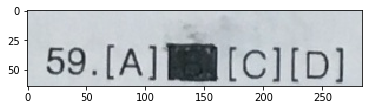

(64, 284, 3)


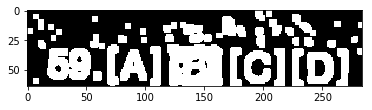

[[32, 17, 27, 37], [33, 79, 27, 23], [29, 119, 35, 47], [34, 184, 28, 23], [35, 237, 27, 23]]
[[33, 79, 27, 23], [29, 119, 35, 47], [34, 184, 28, 23], [35, 237, 27, 23]]


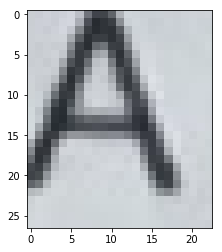

0


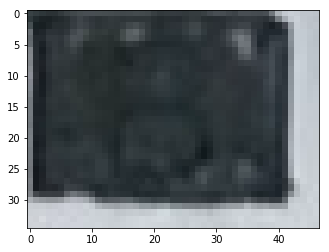

1


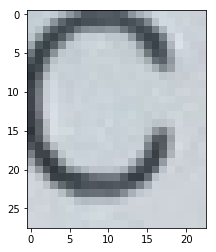

0


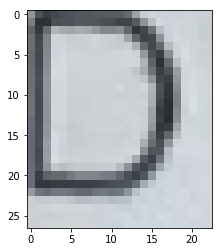

0
B


In [24]:
# model = torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char_2.mkl')
import time
import torchvision.transforms as transforms
model = CNN()
model.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\simple_exam_char_3.pkl'))
def get_exam_flag(image):
    plt.imshow(image,'gray')
    plt.show()
    value = 1
    img = image.copy()
    img = cv2.resize(img,(32,32),interpolation=cv2.INTER_CUBIC)
    img = transforms.ToTensor()(img)
    img = img.unsqueeze(0)
    preds = F.softmax(model(img),dim=1)[0]
    if preds[0] > 0.5:
        value = 0
    del img
    print(value)
    return value
    
    
# 得到答案的选择项
def get_exam_selects(image, rects, selects):
    idx = []
    words = ''
    for i, rect in enumerate(rects):
        y,x,h,w = rect
        crop_img = image[y:y+h, x:x+w]
        if get_exam_flag(crop_img) == 1:
            idx.append(i)
    if len(idx) > 0:
        words = [selects[x] for x in idx]
        words = ''.join(words)
    return words

selects = 'ABCD'    
# path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\iphone8P_101_A-CD-.jpg'
path = 'D:\\59.jpg'
with open(path,'rb') as ff:
    imgbin = ff.read()
    
imgbin = np.frombuffer(imgbin, np.uint8)    
image = cv2.imdecode(imgbin,cv2.IMREAD_COLOR)   
plt.imshow(image,'gray')
plt.show()
print(image.shape)

rect_list = np.array(get_char_rect(image))
rect_inx = np.lexsort([rect_list[:,1]])
rect_list = rect_list[rect_inx]
rect_list = rect_list.tolist()
print(rect_list)
rect_list = rect_list[len(rect_list)-len(selects):]
print(rect_list)
words = get_exam_selects(image,rect_list,selects)
print(words)